<a href="https://colab.research.google.com/github/conster303/PFA_ML_Sandbox_CMS/blob/main/PFA_preprocess_NMFk_FRWY_May.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NMF Nevada PFA sandbox

split into three sections


*   Preprocessing
*   NMF decompostion + kmeans
*   Artificial NN Modeling (and K Nearest Neighbors)


#Preprocess

## import libraries, preprocessing, and set up drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.neural_network import MLPClassifier 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
import tensorflow.keras.backend as K
from scipy.spatial.distance import cdist


from sklearn.decomposition import NMF 
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import normalize

from sklearn.model_selection import cross_val_predict
from mpl_toolkits.axes_grid1 import make_axes_locatable

import random

from scipy.stats import uniform
import pickle
import datetime
import time
import torch
from pathlib import Path
import sys


#If we want to reproduce results/deterministic solutions, pass an integer for random_state

RS = 42 # https://en.wikipedia.org/wiki/42_(number)#The_Hitchhiker's_Guide_to_the_Galaxy
#RS = None

#Set initialization for NMF models 

#init = 'random'
init = 'nndsvd'

#randomness comes from train/test/split as well. 

In [ ]:
#Set up directory where data is stored in your google drive

%cd '/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES'

/content/drive/MyDrive/PFA_March/PFA_MARCH_FILES


In [ ]:
def timeNow():
    '''
    returns current date as a string
    '''
    now = datetime.datetime.now()
    full = "-" + str(now.month) + "-" + str(now.day) + "-" + str(now.year) + \
           '-' + str(now.hour).zfill(2) + ':' + str(now.minute).zfill(2) + ':' + str(now.second).zfill(2)

    return full

To use hdf, pickle, etc., upgrade colab tables

In [ ]:
pip install --upgrade tables

     |████████████████████████████████| 4.3 MB 18.4 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4


In [ ]:
#Import PFA master hdf file preprocessing
import PFA_preprocessing_february2021 as pfa

In [ ]:
tf.__version__

'2.6.0'

In [ ]:
#To access a gpu (not needed unless for clustering) go to runtime tab, select change runtime type, select GPU then run line to check
tf.config.list_physical_devices('GPU')

[]

## load PFA data

In [ ]:
df_features = pd.read_hdf('./PFA_dataframe_grid_march2021_df.h5', 'df_features')

In [ ]:
#Invert fault recency - now young is high

df_features['FaultRecency'] = df_features['FaultRecency']*-1

In [ ]:
df_features.tail()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,HorizGravityGradient2,HorizMagneticGradient2,GravityDensity,MagneticDensity,Heatflow,GeochemistryTemperature2,Tufa_Distance,Travertine_Distance,Silica_Distance,TufaOrTravertine_Distance,FavorableStructuralSettings_Distance,Local-StructuralSetting_Error,Local-QuaternaryFaultRecency_Error,Local-QuaternaryFaultSlipDilation_Error,Local-QuaternaryFaultSlipRate_Error,QuaternaryFaultTraces_Error,HorizGravityGradient_Error,GeodeticStrainRate_Error,QuaternarySlipRate_Error,FaultRecency_Error,Earthquakes_Error,Heatflow_Error,HorizGravityGradient2_Confidence,HorizMagneticGradient2_Confidence,Hillshade-100m,DEM-30m,Fairway,Domain,T37
1727995,999.0,1723.0,R1000C1724,717077.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,-2.11394,-9999.0,0.397940,0.004456,0.000005,-9999,-9999,91.726402,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.577983,0.537311,0.788923,0.403113,0.453099,22.451099,0.190986,4,180,1703,-9999.0,0,12
1727996,999.0,1724.0,R1000C1725,717327.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,-2.11394,-9999.0,0.176091,0.004581,0.000005,-9999,-9999,91.769501,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.577983,0.536572,0.788923,0.403113,0.468096,22.432301,0.203718,4,180,1705,-9999.0,0,12
1727997,999.0,1725.0,R1000C1726,717577.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,-2.11394,-9999.0,0.176091,0.004699,0.000005,-9999,-9999,91.813103,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.600598,0.535831,0.788923,0.403113,0.468096,22.413500,0.190986,4,180,1703,-9999.0,0,12
1727998,999.0,1726.0,R1000C1727,717827.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,-2.11394,-9999.0,0.176091,0.004806,0.000005,-9999,-9999,91.857399,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.615751,0.535089,0.788923,0.403113,0.468096,22.394600,0.165521,4,180,1702,-9999.0,0,12
1727999,999.0,1727.0,R1000C1728,718077.690182,4.508464e+06,nullValue,12,12,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0,0,-9999.0,-1.0,-2.11394,-9999.0,0.176091,0.004899,0.000005,-9999,-9999,91.902298,-9999.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-9999.0,0.615751,0.534346,0.788923,0.403113,0.468096,22.375601,0.165521,4,180,1702,-9999.0,0,12


In [ ]:
df_SSlookup = pd.read_hdf('PFA_structuralSettingsLookup_october2020_df.h5', 'df_SSLookup')
df_SSlookup.head()

,Local_polygon_Id,Local_polygon_overlap_Id,Label,Label2,Label3
0,1,1,AZ,NaN,NaN
1,2,2,FT,NaN,NaN
2,3,3,SO,NaN,NaN
3,4,4,SO,NaN,NaN
4,7,7,SO,NaN,NaN


In [ ]:
#Dataframe with attributes for KGS/wells, names, temperatue values, blind label, Nameplate capacity, well type, and depth
url = 'https://raw.githubusercontent.com/connormacs/Geothermal-Rising-ML-GeoStats-Workshop/main/PFA_TSITES.csv'

df_Tsite_GIS = pd.read_csv(url)
df_Tsite_GIS.head()

,Id,QuaternaryFaultDensity,HorizGravityGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency,Earthquakes,HorizMagneticGradient2,Heatflow,DEM-30m,X_83UTM11,Y_83UTM11,TrainCodeNeg,TrainCodePos,TrainCodePosT130,TrainCodePosT37,NAME,MAX_MAXT,Blind,POWER,E_utm83,N_utm83,Depth(m)
0,6,1.285103,-1.179981,1.327701,-0.875585,-1.595637,0.116588,0.187495,1.161904,0.765071,-0.387379,325827.6902,4261213.766,12,1,12,1,Grant View Hot Springs,53.0,no,0.0,325910.7938,4261123.388,NaN
1,78,0.200934,3.224230,0.042698,0.925116,-0.450002,-0.557711,0.779572,-0.095253,-1.670693,-0.949648,626327.6902,4262713.766,12,1,1,12,Bacon Flat,130.0,yes,0.0,626240.6513,4262689.377,NaN
2,27,0.530642,0.346868,1.670390,2.105045,0.760399,-0.140574,2.492251,1.213427,0.415872,-1.109560,356327.6902,4263213.766,12,1,12,1,Hawthorne 1,97.0,yes,0.0,356239.0985,4263285.061,NaN
3,82,2.520683,-0.845162,-0.276014,-0.920538,-1.178281,-0.632902,1.053704,-0.589872,-1.448916,-0.250680,555077.6902,4263713.766,12,1,1,12,Hot Creek Ranch Hot Spr,160.0,no,0.0,555117.5865,4263714.281,NaN
4,31,0.328629,3.224230,0.004236,0.698215,-0.420560,-0.177550,0.706009,-0.899009,-1.639976,-0.923856,628327.6902,4269213.766,12,1,12,1,Blue Eagle Springs,41.0,no,0.0,628207.4400,4269285.723,NaN


## preprocess data

In [ ]:
extraFeatures = ['GravityDensity', 'MagneticDensity', 
                 'GeochemistryTemperature2',
                 'Silica_Distance', 'TufaOrTravertine_Distance',
                 'DEM-30m', 'FavorableStructuralSettings_Distance']

# extraFeatures = None

Call pfa preprocessing, N for numerical and C for categorical.

N is 0-1.2 scoring for 'Local-StructuralSetting', and C is 19 different structures 1hot encoded (~7 major and 12 hybrid).

The data is reduced (z-score) and scaled (standard). 

Distance from faults = distance_edt, also have option to change to gaussian filter 'gaussianFilter'

In [ ]:
transformDict = {'features': ['Local-StructuralSetting',
                              'Local-QuaternaryFaultRecency',
                              'Local-QuaternaryFaultSlipDilation', 
                              'Local-QuaternaryFaultSlipRate',
                              'QuaternaryFaultTraces'], 
                 'transforms': ['gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'gaussianFilter', 
                                'distance_edt'], 
                 'params': [10, 10, 10, 10, 20]}

# transformDict = {'features': ['QuaternaryFaultTraces'], 
#                  'transforms': ['distance_edt'], 
#                  'params': [20]}

dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_AllNumerical(df_features,
                                                                          transformFeatures=transformDict,
                                                                          extraFeatures=extraFeatures, 
                                                                          prescaleFeatures=True, withMean=True)

# dfn, dfInfo, nullIndexes, scaler = pfa.preprocess_features_LocalNumerical(df_features, 
#                                                                           resetLocal=None,
#                                                                           transformFaultTraces='distance_edt',
#                                                                           extraFeatures=extraFeatures, 
#                                                                           prescaleFeatures=True)

# dfc, dfInfoc, nullIndexesc, scalerc = pfa.preprocess_features_LocalCategorical(df_features.copy(), df_SSlookup,
#                                                                                resetLocal=None,
#                                                                                transformFaultTraces='distance_edt',
#                                                                                extraFeatures=None,
#                                                                                prescaleFeatures=True)

In [ ]:
#Can change name
#dfn = dfn.rename({'QuaternaryFaultTraces':'QuaternaryFaultDistance'},axis=1)
#dfN = dfN.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)
#dfC = dfC.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)


In [ ]:
Xall = dfn.copy()
columns = Xall.columns.to_list()
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [ ]:
featureSets = [

# MASTER SET 1
################################
# featureSet = 0
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 1alt: master set 1 with new gravity/magnetic features substituted
################################
# featureSet = 1
################################
['QuaternaryFaultTraces',
 'GravityDensity',
 'MagneticDensity',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2: master set 1 + all local
################################
# featureSet = 2
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 3: master set 1 + geochemistry direct evidence 
################################
# featureSet = 3
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 4: union of master sets 2 and 3
################################
# featureSet = 4
################################
['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 2a: master set 1 + local structural setting
################################
# featureSet = 5
################################
['Local-StructuralSetting',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 2b: master set 1 + favorable structural settings
################################
# featureSet = 6
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
# MASTER SET 4b: union of master sets 2b and 3
################################
# featureSet = 7
################################
['FavorableStructuralSettings_Distance',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
],
    
# MASTER SET 1m: master set 1 minus geodetic strain rate
################################
# featureSet = 8
################################
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
# 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],
    
]

len(featureSets)

9

In [ ]:
feature_set =2

columns = featureSets[feature_set]

#update the feature set number so it is 1-9
feature_set = feature_set+1

columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

In [ ]:
dfInfo['T37'] = df_features['T37']
dfInfo['Domain'] = df_features['Domain']

dfInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,0.0,0.0,R1C1,286327.690182,4.258714e+06,notNull,12,12,12,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,0.0,1.0,R1C2,286577.690182,4.258714e+06,notNull,12,12,12,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,0.0,2.0,R1C3,286827.690182,4.258714e+06,notNull,12,12,12,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,0.0,3.0,R1C4,287077.690182,4.258714e+06,notNull,12,12,12,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,0.0,4.0,R1C5,287327.690182,4.258714e+06,notNull,12,12,12,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


## select benchmark sites based on trainCode distance

Select trainCode=1: for 83+ and 62- or trainCode=2: 415+ and 310-


In [ ]:
X, y, XyInfo = pfa.makeBenchmarks(dfn, dfInfo, nullIndexes, 
                                          trainCode=1, randomize=True, balance=False)

Number of (+):  83   ; Number of (-):  62


In [ ]:
# X, y, XyInfo = pfa.makeBenchmarks(dfC, dfInfoC, nullIndexesC, 
#                                   trainCode=1, randomize=True, balance=True)

In [ ]:
print( X.shape, y.shape)

(145, 20) (145,)


In [ ]:
X.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
1230984,2.554556,4.495055,5.120417,4.226185,-1.064303,0.739095,-0.414695,0.819395,0.301331,1.395609,0.353466,0.345153,1.098356,-0.640170,1.416784,3.675401,-0.853599,-1.453462,-1.762102,-1.519102
201975,-0.524339,-0.579513,-0.401559,-0.572325,-0.265435,0.836060,-0.857791,-0.039151,-0.369320,0.905377,0.276367,-0.325640,-0.982534,-0.178733,1.416784,-0.185826,2.686270,1.701124,-0.408012,0.619186
448526,6.552448,5.017477,7.984020,4.720836,-0.842737,-0.156645,-0.878400,-0.141914,-0.728853,0.196515,0.508359,-0.711823,-0.892474,-0.524811,0.844115,-0.185826,-0.054237,-1.597306,0.559195,-1.215749
1473551,-0.428533,-0.437781,-0.238323,-0.428817,1.267939,-0.674991,-0.682613,-2.041120,0.626952,-0.350784,1.277005,-1.074379,-0.289358,0.513423,1.302250,-0.185826,-0.291786,-0.078161,-0.348690,-0.257938
919916,0.832489,1.326455,2.736633,1.420725,-1.064303,3.457460,0.224189,0.935494,1.944393,0.280747,-1.099684,-0.370134,0.287695,-1.678404,-0.873892,7.343336,-0.387463,-0.213959,-0.549869,-1.639871


In [ ]:
y

1230984    1
201975     0
448526     1
1473551    0
919916     1
          ..
1172193    1
1315826    1
1556674    0
261720     1
714743     1
Name: labels, Length: 145, dtype: int64

In [ ]:
XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
1230984,712.0,648.0,R713C649,448327.690182,4.436714e+06,notNull,12,1,12,57.0,14716.566058,83.0,107.074113,5.0,60743.770199,107,0,1,2
201975,116.0,1527.0,R117C1528,668077.690182,4.287714e+06,notNull,1,12,12,13.0,48749.952406,43.0,15521.326258,26.0,158.759131,0,0,12,4
448526,259.0,974.0,R260C975,529827.690182,4.323464e+06,notNull,12,1,12,54.0,36988.200152,40.0,132.297372,27.0,51500.747161,244,0,1,4
1473551,852.0,1295.0,R853C1296,610077.690182,4.471714e+06,notNull,1,12,12,14.0,41590.670874,27.0,29287.971083,2.0,130.948648,0,0,12,4
919916,532.0,620.0,R533C621,441327.690182,4.391714e+06,notNull,12,1,1,78.0,75.473372,78.0,75.473372,5.0,57592.682098,129,0,12,2


In [ ]:
#Create Dataframe with training site info
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
XyInfo.reset_index(drop=True, inplace=True)

Tsite= pd.concat([X,XyInfo],axis=1).reset_index(drop=True)
Tsite

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,2.554556,4.495055,5.120417,4.226185,-1.064303,0.739095,-0.414695,0.819395,0.301331,1.395609,0.353466,0.345153,1.098356,-0.640170,1.416784,3.675401,-0.853599,-1.453462,-1.762102,-1.519102,712.0,648.0,R713C649,448327.690182,4.436714e+06,notNull,12,1,12,57.0,14716.566058,83.0,107.074113,5.0,60743.770199,107,0,1,2
1,-0.524339,-0.579513,-0.401559,-0.572325,-0.265435,0.836060,-0.857791,-0.039151,-0.369320,0.905377,0.276367,-0.325640,-0.982534,-0.178733,1.416784,-0.185826,2.686270,1.701124,-0.408012,0.619186,116.0,1527.0,R117C1528,668077.690182,4.287714e+06,notNull,1,12,12,13.0,48749.952406,43.0,15521.326258,26.0,158.759131,0,0,12,4
2,6.552448,5.017477,7.984020,4.720836,-0.842737,-0.156645,-0.878400,-0.141914,-0.728853,0.196515,0.508359,-0.711823,-0.892474,-0.524811,0.844115,-0.185826,-0.054237,-1.597306,0.559195,-1.215749,259.0,974.0,R260C975,529827.690182,4.323464e+06,notNull,12,1,12,54.0,36988.200152,40.0,132.297372,27.0,51500.747161,244,0,1,4
3,-0.428533,-0.437781,-0.238323,-0.428817,1.267939,-0.674991,-0.682613,-2.041120,0.626952,-0.350784,1.277005,-1.074379,-0.289358,0.513423,1.302250,-0.185826,-0.291786,-0.078161,-0.348690,-0.257938,852.0,1295.0,R853C1296,610077.690182,4.471714e+06,notNull,1,12,12,14.0,41590.670874,27.0,29287.971083,2.0,130.948648,0,0,12,4
4,0.832489,1.326455,2.736633,1.420725,-1.064303,3.457460,0.224189,0.935494,1.944393,0.280747,-1.099684,-0.370134,0.287695,-1.678404,-0.873892,7.343336,-0.387463,-0.213959,-0.549869,-1.639871,532.0,620.0,R533C621,441327.690182,4.391714e+06,notNull,12,1,1,78.0,75.473372,78.0,75.473372,5.0,57592.682098,129,0,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.088781,0.164025,-0.207616,0.125381,0.002902,0.603729,0.121143,1.124401,0.156150,1.489985,0.489300,0.855712,1.146997,-0.986248,-0.530291,3.867170,-0.792471,-1.735399,-1.901380,-1.320746,678.0,609.0,R679C610,438577.690182,4.428214e+06,notNull,12,1,12,2.0,12678.753245,81.0,142.464888,5.0,49172.595127,0,0,1,2
141,1.123537,2.033464,2.210983,1.895447,-1.064303,0.904064,-0.394086,1.149432,-0.342335,1.519572,0.698989,-0.711823,1.462918,-0.986248,-0.072156,3.542686,-0.506255,-0.957842,-0.918698,-1.244403,761.0,818.0,R762C819,490827.690182,4.448964e+06,notNull,12,1,12,57.0,32652.948912,50.0,125.614881,42.0,69712.771846,125,0,1,3
142,-0.532810,-0.586230,-0.402901,-0.584993,4.524266,-0.743702,-0.950532,-1.113649,2.177095,1.117178,0.726471,-1.542368,0.323909,1.090220,1.187716,-0.185826,-0.859950,-0.924020,0.045930,1.605217,900.0,1474.0,R901C1475,654827.690182,4.483714e+06,notNull,1,12,12,14.0,14412.752462,14.0,14412.752462,20.0,83.887000,0,0,12,4
143,0.852885,1.386465,2.877634,0.452692,-1.064303,2.162750,1.419519,-0.321438,0.210772,-0.372937,-1.583478,0.118718,0.202172,-1.678404,-0.530291,7.119719,-1.159175,-1.737925,-0.289368,-1.633305,151.0,792.0,R152C793,484327.690182,4.296464e+06,notNull,12,1,1,10.0,99.423208,10.0,99.423208,56.0,76012.613377,236,0,12,4


## Create a dataframe with all the normalized data
combines dfN and dfNInfo and includes domains, used for cluster projection into fairway and for fairway NMF/PCA

In [ ]:
#Create a dataframe with all the normalized data

Info = pd.concat([dfn,dfInfo],axis=1,sort=False)
Info.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37,Domain
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,-0.664854,-0.469155,2.209502,0.047583,1.320938,1.645851,-0.185826,0.568055,1.088169,0.615938,-0.006918,0.0,0.0,R1C1,286327.690182,4.258714e+06,notNull,12,12,12,9.0,82070.110132,61.0,34166.449170,22.0,122848.502942,0,0,12,1
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,-0.664854,-0.459131,2.211017,0.055473,1.205579,1.645851,-0.185826,0.566441,1.086893,0.510190,0.007384,0.0,1.0,R1C2,286577.690182,4.258714e+06,notNull,12,12,12,9.0,81993.349012,61.0,34115.759156,22.0,122726.185082,0,0,12,1
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,-0.664854,-0.407871,2.217023,0.062990,1.205579,1.645851,-0.185826,0.564841,1.085688,0.303852,0.023286,0.0,2.0,R1C3,286827.690182,4.258714e+06,notNull,12,12,12,9.0,81917.278930,61.0,34066.828392,22.0,122604.254961,0,0,12,1
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,-0.664854,-0.368710,2.211017,0.070240,1.090220,1.645851,-0.185826,0.563255,1.084554,0.347699,0.040750,0.0,3.0,R1C4,287077.690182,4.258714e+06,notNull,12,12,12,9.0,81841.901813,61.0,34019.664470,22.0,122482.713736,0,0,12,1
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,-0.640521,-0.363559,2.208005,0.077179,1.090220,1.645851,-0.185826,0.561684,1.083491,0.437972,0.059734,0.0,4.0,R1C5,287327.690182,4.258714e+06,notNull,12,12,12,9.0,81767.219578,61.0,33974.274746,22.0,122361.562567,0,0,12,1


In [ ]:
#Check how many domains there are, should be 5 (4 plus study area)
print (Info['Domain'].unique())

[1 3 4 0 2]


(1728000,)


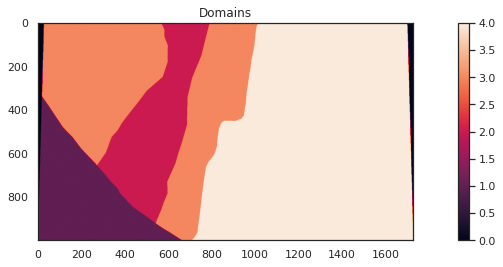

In [ ]:
SD = Info['Domain'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))
#flip it so it is right side up
SD = np.flipud(SD)
#np.fliplr
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD)
plt.title('Domains')
plt.colorbar()
# 1 wl, 2 cnsb, 3 wgb, 4 carb

## Explore data at training sites, structures and domains

In [ ]:
##############################
#Tsites
Tsite_Set = Tsite.copy()[columns]

Tsite_Set.rename(columns = {'QuaternaryFaultTraces':'QuaternaryFaultDistance'}, inplace = True)
Tsite_Pos = Tsite[Tsite['TrainCodePos']!=12]
Tsite_Neg = Tsite[Tsite['TrainCodePos']==12]
Tsite_PosLOW = Tsite_Pos[Tsite_Pos['TrainCodePosT130']==12] #lower  pos
Tsite_PosBM = Tsite_Pos[Tsite_Pos['TrainCodePosT130']!=12] #Benchmark  pos

##############################
#Structures

#Select data within structures 
df_Struct = Info.copy().loc[Info['Local_polygon_Id'] != 0] 
#take mean values
df_mean_struct = df_Struct.groupby('Local_polygon_Id').mean()

#Reindex structures, there may be 384 total, but they are grouped so that there are actuall 365 and 19 hybrid 
df_mean_struct.index = range(len(df_mean_struct))

Struc_Set = df_mean_struct.copy()[columns]

#Labeled dataframe of which structures host Known Geothermal Systems to append after groupby transformation
yStruct = (df_Struct.groupby(['Local_polygon_Id'])['TrainCodePos'].min())
yStruct.index = range(len(yStruct))
yStruct = pd.DataFrame(yStruct) 

 # I use 0 instead of 
yStruct['TrainCodePos'].replace({12:0, 4:0,9:0,10:0,6:0,8:0,7:0}, inplace=True)
#Replace/update TrainCodePos values 
df_mean_struct = df_mean_struct.drop(['TrainCodePos'], axis = 1)
yStruct.rename(columns = {'TrainCodePos':'TrainCodePos2'}, inplace = True) #Update name to have a 2
df_mean_struct['TrainCodePos'] = yStruct['TrainCodePos2']
##############################
#Domains

WL = Info[Info['Domain'] == 1]
CNSB =  Info[Info['Domain'] == 2]
WGB =  Info[Info['Domain'] == 3]
CAQ = Info[Info['Domain'] == 4]

FRWY_Set = Info.copy()[columns]
FRWY_Set.rename(columns = {'QuaternaryFaultTraces':'QuaternaryFaultDistance'}, inplace = True)

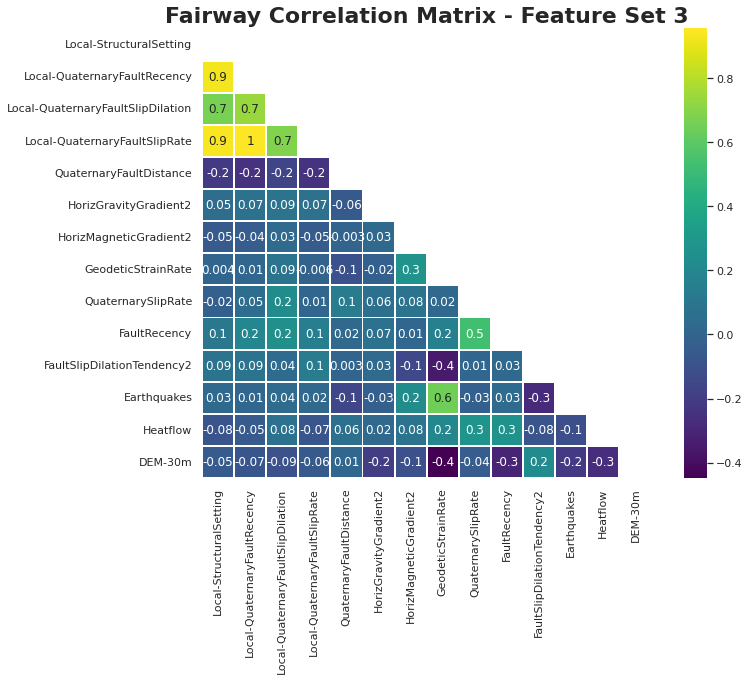

<Figure size 842.4x595.44 with 0 Axes>

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
FRWY_correlation_mat = FRWY_Set.corr()

# Generate a mask for the upper triangle; True = do NOT show
mask = np.zeros_like(FRWY_correlation_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


ax = sns.heatmap(FRWY_correlation_mat, mask = mask, annot = True, linewidths=.95, cmap = 'viridis',annot_kws={"size": 12}, fmt='.1g')

ax.fontweight='bold'
ax.set_aspect("equal")

plt.title('Fairway Correlation Matrix - Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

plt.savefig('March_Figs/FRWY_PearsCorrMatrix ' + str(feature_set) + '.png') 

plt.show()
plt.tight_layout()

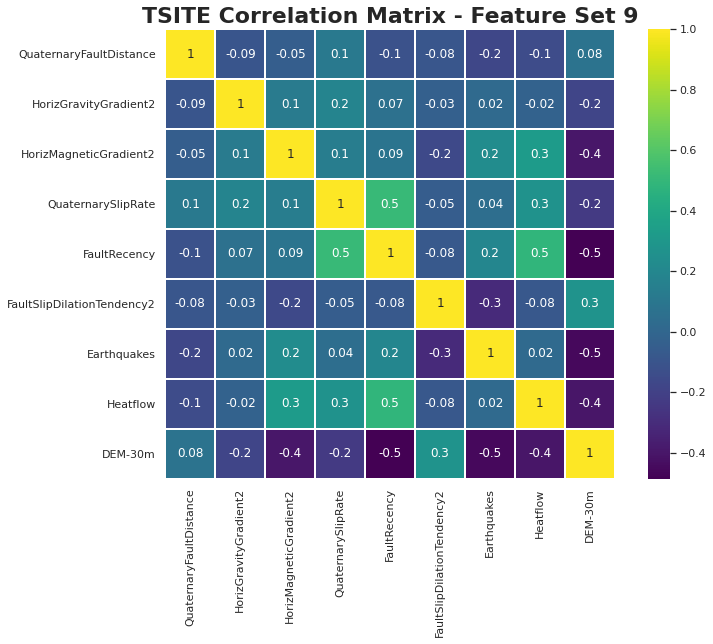

<Figure size 842.4x595.44 with 0 Axes>

In [ ]:


TSITE_correlation_mat = Tsite_Set.corr()

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
FRWY_correlation_mat = FRWY_Set.corr()

ax = sns.heatmap(TSITE_correlation_mat, annot = True, linewidths=.95, cmap = 'viridis',annot_kws={"size": 12}, fmt='.1g')

ax.fontweight='bold'
ax.set_aspect("equal")

plt.title('TSITE Correlation Matrix - Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');


plt.savefig('March_Figs/TSITE_PearsCorrMatrix ' + str(feature_set) + '.png') 
plt.show()
plt.tight_layout()

#NMF Anaylsis

Steps



*   Convert data to be non-negative
*   Normalize data between 0 and 1
*   Determine k: Reconstruction error, silhoutte width, and variance explained.
*   To get reproducable results random_state and random_init are set to an integer. 

Notes/To do

* Determining K for the Fairway needs fixing, can't loop over different k values because of time/computational cost.
*   Integrate K-fold cross validation. Compuationaly costly 
*  Favorability modeling - to transfer NMF t site characteristics onto NMF fairway decomposition need same #k..is an alternative option turning W's (mixing matricies) into singular vectors? 

*   Matrix value W and magnitude will vary depending on if you use regularization &/or singular value decomposition. Note to make W the same magnitude before ANN modeling if training on t site NMF and testing on FRWY NMF. This seems to be source of variance in range of favorabliity values.

*   Explore better ways to optimize this model.
*   -Initialization (method to initialize procedure). The default is non negative double singular value decomposition. Using 'random' (non-negative random matricies scaled with sqrt(X.mean()/n_components) seems like another good option, though non-unique. 
*   -alpha (regularization term). default is 0 (no regularization). 
*   K means groups and NMF groups sometimes flopped around by algorithms, watch symbology. 



In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import NMF 
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import normalize


## NMF Tsites

### FRWY NMF Prep

In [ ]:
#Make data non-negative. Add the min value of each variable to all row values.

Tsite_Set += np.abs(Tsite_Set.copy().min())

In [ ]:
#Scale data from 0 to 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Tsite_SetScaled = scaler.fit_transform(Tsite_Set)

### FIND K: Reconstruction error Variance and Kmeans Sillhoutte width
This is very slow with the fairway, needs modifying

In [ ]:
#Explained variance calcuation
def get_variance(model, data, scorer=metrics.explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data)) #Transform data back to original space
    return scorer(data, prediction)

#Get another score? https://scikit-learn.org/stable/modules/model_evaluation.html

n = len(Tsite_Set.columns)

#Start at 2 and go up to 8
K = range(2,n,1)

Variance= []
Reconstruction_err = []
Sill_score = []
for k in K:
    nmf = NMF(n_components=k, init = init, random_state=RS).fit(Tsite_SetScaled) #learn an NMF model for train data and evaluate its performance
    Variance.append(get_variance(nmf,Tsite_SetScaled))
    Reconstruction_err.append(nmf.reconstruction_err_)
    clusterer = KMeans(n_clusters=k,random_state = RS)
    W = nmf.fit_transform(Tsite_SetScaled)
    pred = clusterer.fit_predict(W)
    score = silhouette_score(W, pred)
    Sill_score.append(score)
print(Variance)

[0.35191618625745635, 0.4677423522625277, 0.5925685822960021, 0.7061299914288981, 0.8170179531848487, 0.8837443590565386, 0.9528163934660454]


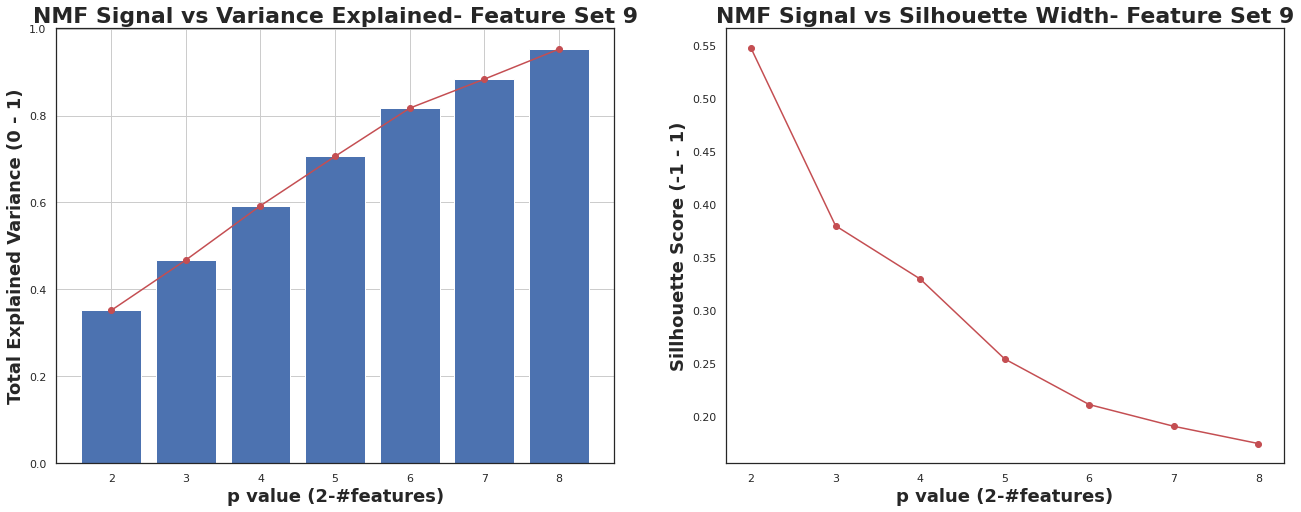

In [ ]:
plt.rc('figure', figsize=(22, 8))
#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')


plt.subplot(121)

plt.bar(K,Variance)
plt.plot(K, Variance, c='r',marker='o')

plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Total Explained Variance (0 - 1)',fontsize = 18,fontweight='bold')

plt.title('NMF Signal vs Variance Explained- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

#plt.legend(fontsize = 18)
plt.grid(True)


plt.subplot(122)

plt.plot(K,Sill_score,c='r',marker='o')
plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Sillhouette Score (-1 - 1)',fontsize = 18,fontweight='bold')

plt.title('NMF Signal vs Silhouette Width- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

"""
plt.subplot(133)
plt.bar(K,Reconstruction_err)

plt.plot(K, Reconstruction_err, c='r',marker='o')


plt.xlabel('p value',fontsize = 18,fontweight='bold')
plt.ylabel('Reconstruction Error',fontsize = 18,fontweight='bold')
#plt.legend(fontsize = 18)

plt.grid(True)
plt.title('NMF Signal vs Reconstruction Error- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

"""
plt.savefig('March_Figs/NMF/TSITES/NMF_Tsite_find_p_Set ' + str(feature_set) + '.png') 

### NMF Analysis

In [ ]:
components = 4
nmfmodel = NMF(n_components= components, init = init, random_state=RS) #init is the method to initialize the procedure.


W = nmfmodel.fit_transform(Tsite_SetScaled)

H = nmfmodel.components_

H = normalize(H)

H.shape

(4, 9)

In [ ]:
init

'nndsvd'

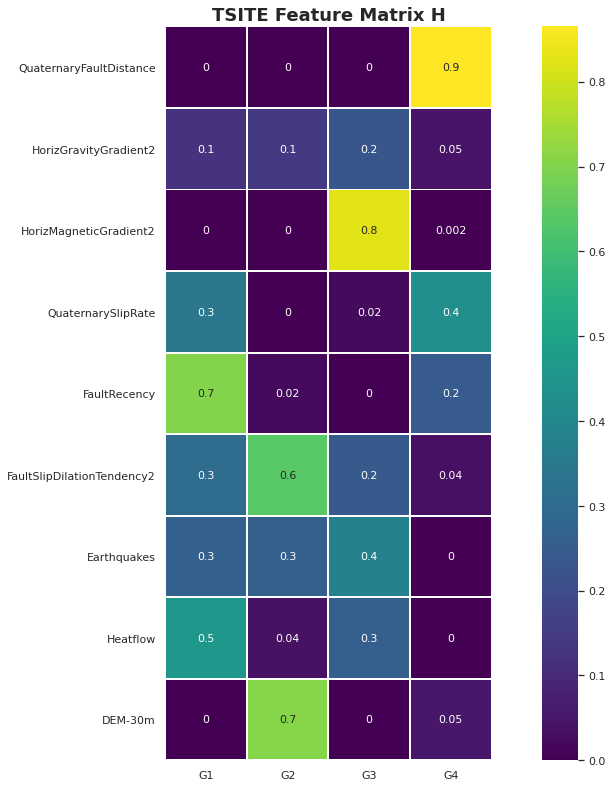

In [ ]:
import seaborn as sns
#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))
H_t= H.transpose()
ax = sns.heatmap(H_t,
                 cmap='viridis', linewidths=.95,
                xticklabels=[ "G"+str(FRWY_Set) for FRWY_Set in range(1,nmfmodel.n_components_+1)],
                 yticklabels=list(FRWY_Set.columns), 
                 annot=True, annot_kws={"size": 11}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")
ax.set_title("TSITE Feature Matrix H",fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout
plt.savefig('March_Figs/NMF/TSITES/NMF_TSITE' + str(components) + ' Signals-FM' +'Set' + str(feature_set)  + '.png')

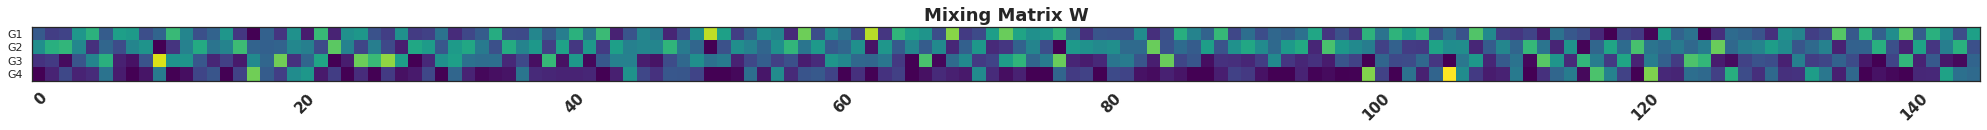

<Figure size 1584x576 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(28,28.5))
im = ax.imshow(W.transpose(), cmap = 'viridis') # cmap='YlGnBu'

# We want to show all ticks...
ax.set_yticks(range(nmfmodel.n_components_))
ax.set_yticklabels( "G"+str(TSite_Set_Group) for TSite_Set_Group in range(1,nmfmodel.n_components_+1))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=15,fontweight='bold')


ax.set_title("Mixing Matrix W",fontsize=18,fontweight='bold');
fig.tight_layout()
plt.show()
plt.savefig('March_Figs/NMF/TSITES/NMF_TSITE' + str(components) + ' Signals-MM' +'Set' + str(feature_set)  + '.png')

In [ ]:
#Make magnitude of Ws same as T site Ws for transfer learning

Ws_Tsite = pd.DataFrame(W,columns= ["G"+str(Tsite_SetScaled) for Tsite_SetScaled in range(1,nmfmodel.n_components_+1)])
Ws_Tsite

,G1,G2,G3,G4
0,0.149996,0.261291,0.077429,0.000000
1,0.095897,0.334093,0.089852,0.053284
2,0.105682,0.348455,0.014712,0.114426
3,0.277779,0.245350,0.138486,0.052280
4,0.339181,0.072524,0.237773,0.064374
...,...,...,...,...
140,0.156340,0.304337,0.051158,0.057770
141,0.335232,0.083650,0.147445,0.061707
142,0.255122,0.225560,0.034782,0.303701
143,0.122244,0.335321,0.013910,0.194104


In [ ]:
Ws_Tsite = pd.concat([Tsite_Set,Ws_Tsite], axis=1, sort=False)
Ws_Tsite

,QuaternaryFaultDistance,HorizGravityGradient2,HorizMagneticGradient2,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,DEM-30m,G1,G2,G3,G4
0,0.198175,2.100420,0.298832,0.654346,1.191346,4.444023,1.812793,2.118937,1.534635,0.149996,0.261291,0.077429,0.000000
1,0.495437,1.015373,0.597665,1.028114,1.275384,3.875043,2.729827,1.287620,2.623066,0.095897,0.334093,0.089852,0.053284
2,1.107832,2.467475,0.030914,1.220586,1.694072,4.681194,2.643329,0.172113,2.153648,0.105682,0.348455,0.014712,0.114426
3,0.297262,3.370022,0.886193,2.541400,2.961999,4.505683,2.047268,2.747068,1.885409,0.277779,0.245350,0.138486,0.052280
4,1.067205,1.940331,1.164416,1.899871,3.519345,4.055983,3.869175,3.154009,0.095431,0.339181,0.072524,0.237773,0.064374
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.443133,0.788436,0.401878,1.399116,2.271030,4.288671,3.263990,0.485694,2.068534,0.156340,0.304337,0.051158,0.057770
141,0.297262,0.824397,1.020152,3.330403,3.523413,2.692545,2.643329,3.011581,1.003316,0.335232,0.083650,0.147445,0.061707
142,3.283371,2.550506,0.216396,2.810083,3.420926,3.929421,1.812793,2.470689,1.766765,0.255122,0.225560,0.034782,0.303701
143,2.080837,2.054506,0.010305,1.547264,1.914468,4.672911,2.596069,0.697874,2.125277,0.122244,0.335321,0.013910,0.194104


### KMeans

In [ ]:
from sklearn.cluster import MiniBatchKMeans

cols = FRWY_Set.columns


nCluster = 4

Kmean = MiniBatchKMeans(n_clusters=nCluster, init = 'k-means++',verbose=0,random_state= RS)


Kmean.fit(Ws_Tsite[['G1','G2','G3','G4']])

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
Kmean.labels_

array([3, 3, 3, 0, 0, 2, 0, 3, 3, 2, 0, 2, 3, 3, 3, 3, 1, 2, 2, 1, 1, 0,
       3, 3, 2, 2, 2, 0, 3, 3, 2, 2, 3, 2, 0, 3, 1, 3, 2, 3, 0, 3, 0, 2,
       1, 3, 3, 3, 2, 2, 0, 0, 3, 1, 0, 1, 3, 0, 3, 2, 2, 3, 0, 2, 0, 3,
       2, 3, 0, 2, 1, 0, 0, 2, 0, 0, 0, 3, 3, 3, 2, 2, 0, 3, 2, 0, 0, 3,
       0, 3, 3, 3, 2, 3, 3, 0, 3, 3, 3, 1, 2, 0, 0, 0, 3, 1, 1, 0, 0, 3,
       1, 3, 2, 2, 1, 2, 1, 1, 2, 3, 1, 0, 3, 2, 2, 3, 1, 3, 3, 1, 3, 2,
       1, 1, 0, 1, 0, 3, 0, 0, 3, 0, 1, 3, 0], dtype=int32)

In [ ]:
#Join data into df_out data frame
centers = np.copy(Kmean.cluster_centers_)

Labels = Kmean.labels_

df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([Ws_Tsite,Tsite, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

Last 5 rows of df_out:
     QuaternaryFaultDistance  HorizGravityGradient2  HorizMagneticGradient2  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency2  Earthquakes  Heatflow   DEM-30m        G1        G2        G3        G4  Local-StructuralSetting  Local-QuaternaryFaultRecency  Local-QuaternaryFaultSlipDilation  Local-QuaternaryFaultSlipRate  QuaternaryFaultTraces  HorizGravityGradient2  HorizMagneticGradient2  GeodeticStrainRate  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency2  Earthquakes  Heatflow  GravityDensity  MagneticDensity  GeochemistryTemperature2  Silica_Distance  TufaOrTravertine_Distance   DEM-30m  FavorableStructuralSettings_Distance    row  column      id_rc      X_83UTM11     Y_83UTM11 NullInfo  TrainCodeNeg  TrainCodePos  TrainCodePosT130  PosSite130_Id  PosSite130_Distance  PosSite_Id  PosSite_Distance  NegSite_Id  NegSite_Distance  Local_polygon_Id  Local_polygon_overlap_Id  T37  Domain  KMeansGrp  Grp0_CntrX  Grp0_CntrY  Grp1_CntrX  Grp1_Cnt

In [ ]:
centers

array([[0.33758331, 0.10901442, 0.17030285, 0.04815994],
       [0.12764398, 0.22628554, 0.12650611, 0.27255628],
       [0.16424374, 0.17870958, 0.28307608, 0.08079442],
       [0.14736597, 0.29050661, 0.06372666, 0.05839613]])

In [ ]:

#Groups for positive sites
group1 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
label1 = 'Positive T-Site - Cluster 1: ' + str(len(group1))
group2 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
label2 = 'Positive T-Site - Cluster 2: ' + str(len(group2))
group3 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
label3 = 'Positive T-Site - Cluster 3: ' + str(len(group3))
group4 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
label4 = 'Positive T-Site - Cluster 4: ' + str(len(group4))

#Groups for negative sites 
group5 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
label5 = 'Negative T-Site - Cluster 1: ' + str(len(group5))
group6 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
label6 = 'Negative T-Site - Cluster 2: ' + str(len(group6))
group7 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
label7 = 'Negative T-Site - Cluster 3: ' + str(len(group7))
group8 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]
label8 = 'Negative T-Site - Cluster 4: ' + str(len(group8))


In [ ]:
#Colors for plots
c1 = 'violet'
c2 = 'yellowgreen'
c3 = 'cyan'
c4 = 'red'

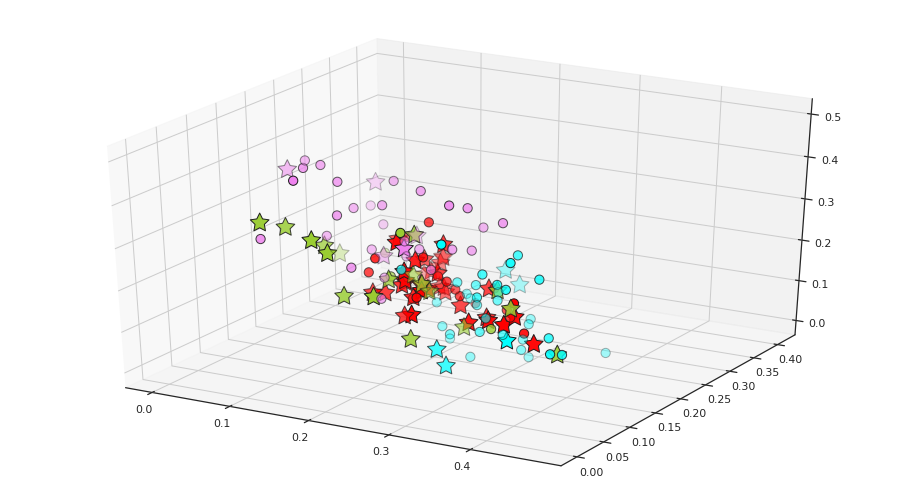

In [ ]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (16, 9))

ax = plt.axes(projection ="3d")

#Look at training sites in 3D
ax.scatter3D(group1['G1'], group1['G2'],group1['G3'], c='cyan',edgecolors='k',s=85,marker='o', label=label1)
ax.scatter3D(group2['G1'], group2['G2'],group2['G3'], c='yellowgreen',edgecolors='k',s=85,marker='o', label=label2)
ax.scatter3D(group3['G1'], group3['G2'],group3['G3'], c='violet',edgecolors='k',s=85,marker='o', label=label3)
ax.scatter3D(group4['G1'], group4['G2'],group4['G3'], c='red',edgecolors='k',s=85,marker='o', label=label4)



ax.scatter3D(group5['G1'], group5['G2'],group5['G3'], c='cyan',edgecolors='k',s=385,marker=(5, 1), label=label5)
ax.scatter3D(group6['G1'], group6['G2'],group6['G3'], c='yellowgreen',edgecolors='k',s=385, marker=(5, 1), label=label6)
ax.scatter3D(group7['G1'], group7['G2'],group7['G3'], c='violet',edgecolors='k',s=385, marker=(5, 1),label=label7)
ax.scatter3D(group8['G1'], group8['G2'],group8['G3'], c='red',edgecolors='k',s=385, marker=(5, 1),label=label8)

plt.savefig('March_Figs/NMF/TSITES/NMF_TSITE' + str(components) + ' 3D_Cluster ' +'Set' + str(feature_set)  + '.png')

In [ ]:
#Colors for plots
c1 = 'violet'
c2 = 'yellowgreen'
c3 = 'cyan'
c4 = 'red'

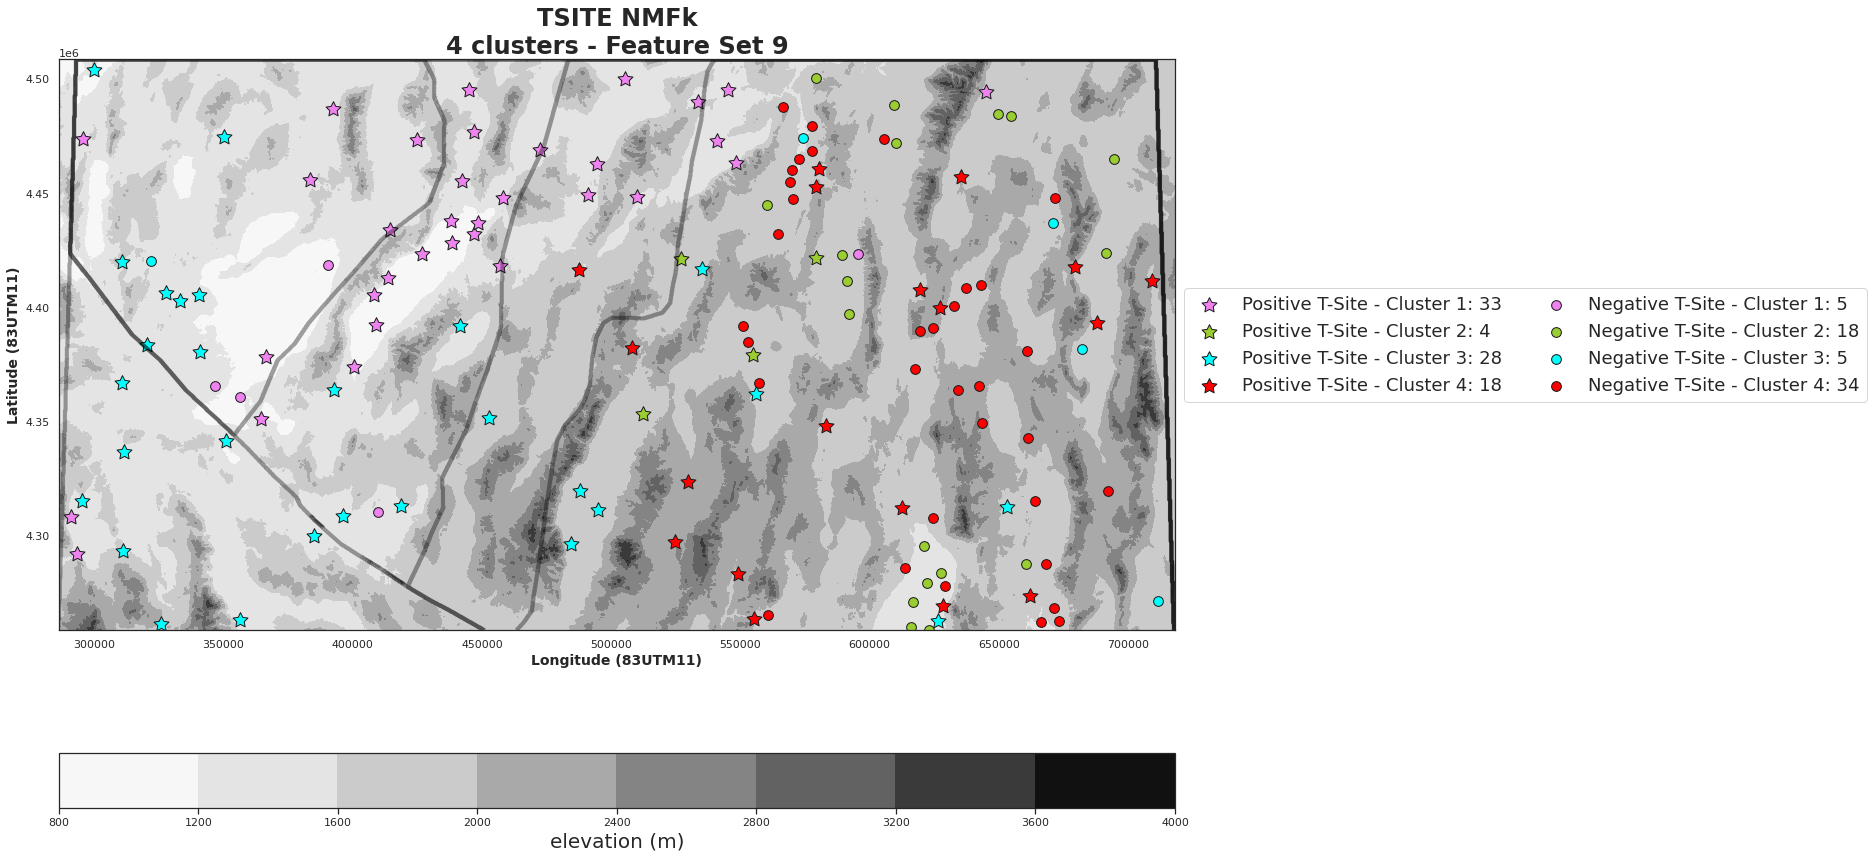

In [ ]:
plt.subplots(figsize=(20,15))

#Set up mesh grid plot for Domains and DEM
a = Info['X_83UTM11']
b = Info['Y_83UTM11']
Domains = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values
DEM = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values
X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)

plt.contour(Xa,Ya,Domains,colors='black', linewidths=4, alpha=0.2) 

plt.contourf(Xa,Ya,DEM,cmap = 'Greys')
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')


#Plot positive sites
plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'],c=c1  ,edgecolors='k', marker=(5, 1),s=245, label=label1)
plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'], c=c2, edgecolors='k',marker=(5, 1),s=245,label=label2)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'],   c=c3, edgecolors='k',marker=(5, 1),s=245, label=label3)
plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c=c4, edgecolors='k',marker=(5, 1),s=245,label=label4)

#Plot negative sites
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'], c=c1, marker='o',edgecolors='k',s=95,label=label5)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'],  c=c2, marker='o',edgecolors='k',s=95,label=label6)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],   c=c3, marker='o',edgecolors='k',s=95,label=label7)
plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'],   c=c4, marker='o',edgecolors='k',s=95,label=label8)

ncols = 2
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', ncol=ncols, bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)

plt.title('TSITE NMFk\n' + str(nCluster) + ' clusters - Feature Set ' + str(feature_set),fontsize=24,fontweight='bold');

plt.tight_layout
plt.savefig('March_Figs/NMF/TSITES/NMF_TSITE_MAP' + str(nCluster) +'Set ' + str(feature_set)  +'.png')

## NMF Fairway

### FRWY NMF Prep

In [ ]:
#Make data non-negative. Add the min value of each variable to all row values.

FRWY_Set += np.abs(FRWY_Set.copy().min())

In [ ]:
FRWY_Set

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultDistance,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,DEM-30m
0,0.009130,0.017330,0.003458,0.016409,1.585400,0.901391,0.000000,4.287202,2.437530,1.897399,7.876606,5.222965,2.999020,2.646279
1,0.009042,0.017162,0.003425,0.016250,1.585400,1.215661,0.000000,4.287202,2.437530,1.897399,7.886629,5.224480,3.006910,2.540531
2,0.008868,0.016832,0.003359,0.015938,1.585400,1.523959,0.000000,4.287202,2.437530,1.897399,7.937889,5.230486,3.014427,2.334193
3,0.008613,0.016349,0.003263,0.015480,1.588493,1.747685,0.000000,4.287202,2.437530,1.897399,7.977051,5.224480,3.021677,2.378040
4,0.008285,0.015727,0.003138,0.014891,1.597738,1.844715,0.000000,4.287202,2.448054,1.921732,7.982202,5.221469,3.028616,2.468313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727995,0.532810,0.586230,0.402901,0.584993,1.064303,1.408202,1.146319,2.548743,3.078613,2.562253,8.345760,3.013463,2.951437,2.030341
1727996,0.532810,0.586230,0.402901,0.584993,1.064303,1.408202,1.146319,2.548743,3.078613,2.562253,8.345760,3.013463,2.951437,2.030341
1727997,0.532810,0.586230,0.402901,0.584993,1.064303,1.408202,1.146319,2.548743,3.078613,2.562253,8.345760,3.013463,2.951437,2.030341
1727998,0.532810,0.586230,0.402901,0.584993,1.064303,1.408202,1.146319,2.548743,3.078613,2.562253,8.345760,3.013463,2.951437,2.030341


In [ ]:
#Scale data from 0 to 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
FRWY_Set_GroupScaled = scaler.fit_transform(FRWY_Set)

### FIND K: Reconstruction error Variance and Kmeans Sillhoutte width
This is very slow with the fairway, needs modifying

In [ ]:
#Explained variance calcuation
from sklearn.cluster import MiniBatchKMeans

def get_variance(model, data, scorer=metrics.explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data)) #Transform data back to original space
    return scorer(data, prediction)

#Get another score? https://scikit-learn.org/stable/modules/model_evaluation.html
n = len(FRWY_Set.columns)

#Start at 2 and go up to 8
K = range(2,n,1)

Variance= []
Reconstruction_err = []
Sill_score = []
for k in K:
    nmf = NMF(n_components=k, init = init, random_state=RS).fit(FRWY_Set_GroupScaled) #learn an NMF model for train data and evaluate its performance
    Variance.append(get_variance(nmf,FRWY_Set_GroupScaled))
    W_FRWY = nmf.fit_transform(FRWY_Set_GroupScaled)
    #pca_score = pca.fit_transform(FRWY_Set)
print(Variance)

In [ ]:
#Isolate Tsites from W of full fairway for sill score (cant do whole fairway with sill score algorithm)

nmfFRWY_df = pd.DataFrame(W_FRWY,columns=[ "G"+str(FRWY_Set) for FRWY_Set in range(1,nmf.n_components_+1)])
nmf_FRWY_Info = pd.concat([Info,nmfFRWY_df], axis=1, sort=False)
FRWY_Tsites = nmf_FRWY_Info[(nmf_FRWY_Info['TrainCodePos'] == 1) | (nmf_FRWY_Info['TrainCodeNeg'] == 1)]
FRWY_Tsites.drop(FRWY_Tsites[FRWY_Tsites['NullInfo']== 'nullValue'].index, inplace = True) 
FRWY_Tsites_Ws = pd.DataFrame(FRWY_Tsites,columns= ["G"+str(FRWY_Set) for FRWY_Set in range(1,components+1)])
FRWY_Tsites_Ws.reset_index(drop=True, inplace=True) 

In [ ]:
Sill_score = []
for k in K:
    clusterer = MiniBatchKMeans(n_clusters=k,random_state = RS)
    pred = clusterer.fit_predict(FRWY_Tsites_Ws)
    score = silhouette_score(FRWY_Tsites_Ws, pred)
    Sill_score.append(score)

In [ ]:
plt.rc('figure', figsize=(22, 8))

#plt.suptitle('Picking Signals (p) for NMF',fontsize = 38,fontweight='bold')


plt.subplot(121)

plt.bar(K,Variance)
plt.plot(K, Variance, c='r',marker='o')

plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Total Explained Variance (0 - 1)',fontsize = 18,fontweight='bold')

plt.title('NMF Signal vs Variance Explained- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

#plt.legend(fontsize = 18)
plt.grid(True)


plt.subplot(122)

plt.plot(K,Sill_score,c='r',marker='o')
plt.xlabel('p value (2-#features)',fontsize = 18,fontweight='bold')
plt.ylabel('Sillhouette Score (-1 - 1)',fontsize = 18,fontweight='bold')

plt.title('NMF Signal vs Silhouette Width- Feature Set '+ str(feature_set),fontsize = 22,fontweight='bold');

plt.savefig('March_Figs/NMF/FRWY/NMF_FRWY_find_p_Set ' + str(feature_set) + '.png') 

### NMF Analysis

In [ ]:
components = 3

RS = None
nmfmodel = NMF(n_components= components, init = init, random_state=RS) #init is the method to initialize the procedure.


W = nmfmodel.fit_transform(FRWY_Set_GroupScaled)

H = nmfmodel.components_

H = normalize(H)

H.shape

(3, 14)

In [ ]:
init

'nndsvd'

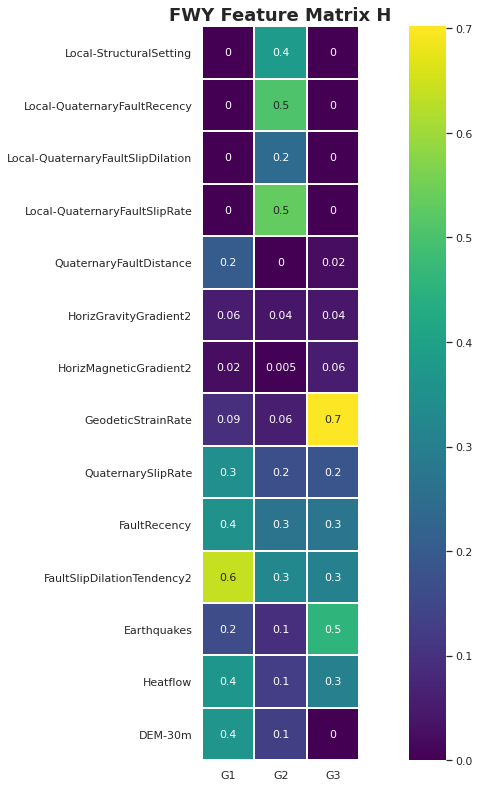

In [ ]:
import seaborn as sns
#we can see influence on each of the components by features.
fig= plt.figure(figsize=(18,13.5))
H_t= H.transpose()
ax = sns.heatmap(H_t,
                 cmap='viridis', linewidths=.95,
                xticklabels=[ "G"+str(FRWY_Set_Group) for FRWY_Set_Group in range(1,nmfmodel.n_components_+1)],
                 yticklabels=list(FRWY_Set.columns), 
                 annot=True, annot_kws={"size": 11}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
ax.set_aspect("equal")
ax.set_title("FWY Feature Matrix H",fontsize=18,fontweight='bold')
#ax.invert_yaxis()
plt.tight_layout
plt.savefig('March_Figs/NMF/FRWY/NMF_FRWY' + str(components) + ' Signals-FM' +'Set' + str(feature_set)  + '.png')

In [ ]:
nmfFRWY_df = pd.DataFrame(W,columns=[ "G"+str(FRWY_Set) for FRWY_Set in range(1,nmfmodel.n_components_+1)])
nmf_FRWY_Info = pd.concat([Info,nmfFRWY_df], axis=1, sort=False)
FRWY_Tsites = nmf_FRWY_Info[(nmf_FRWY_Info['TrainCodePos'] == 1) | (nmf_FRWY_Info['TrainCodeNeg'] == 1)]
FRWY_Tsites.drop(FRWY_Tsites[FRWY_Tsites['NullInfo']== 'nullValue'].index, inplace = True) 
FRWY_Tsites_Ws = pd.DataFrame(FRWY_Tsites,columns= ["G"+str(FRWY_Set) for FRWY_Set in range(1,components+1)])
FRWY_Tsites_Ws.reset_index(drop=True, inplace=True) 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
FRWY_Tsites_Ws

,G1,G2,G3
0,0.010276,0.024227,0.021380
1,0.017021,0.005826,0.020108
2,0.013968,0.000000,0.030136
3,0.021864,0.004400,0.020501
4,0.004572,0.042031,0.021815
...,...,...,...
140,0.000000,0.061000,0.027050
141,0.018844,0.028268,0.016059
142,0.028403,0.003751,0.013309
143,0.023217,0.000000,0.011189


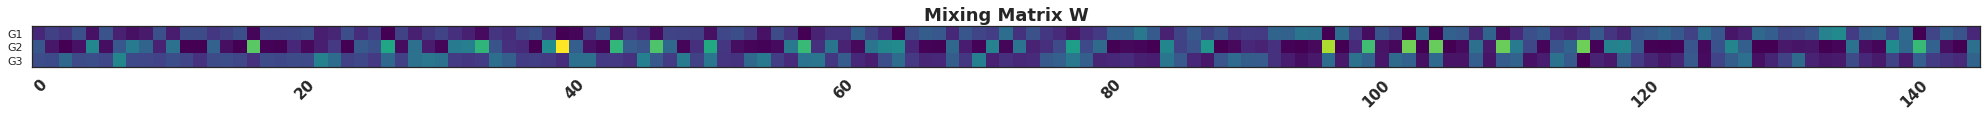

In [ ]:
fig, ax = plt.subplots(figsize=(28,28.5))
im = ax.imshow(FRWY_Tsites_Ws.transpose(), cmap = 'viridis') # cmap='YlGnBu'

# We want to show all ticks...
ax.set_yticks(range(FRWY_Tsites_Ws.shape[1]))
ax.set_yticklabels( "G"+str(TSite_Set) for TSite_Set in range(1,nmfmodel.n_components_+1))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=15,fontweight='bold')


ax.set_title("Mixing Matrix W",fontsize=18,fontweight='bold')
fig.tight_layout()
plt.show()

### KMeans

In [ ]:
from sklearn.cluster import MiniBatchKMeans

cols = FRWY_Set.columns


nCluster = 3

Kmean = MiniBatchKMeans(n_clusters=nCluster, init = 'k-means++',verbose=0,random_state= RS)


Kmean.fit(nmfFRWY_df[['G1','G2','G3']])

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=3, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [ ]:
Kmean.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
#Join data into df_out data frame
centers = np.copy(Kmean.cluster_centers_)

Labels = Kmean.labels_

df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([nmf_FRWY_Info, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

Last 5 rows of df_out:
         Local-StructuralSetting  Local-QuaternaryFaultRecency  Local-QuaternaryFaultSlipDilation  Local-QuaternaryFaultSlipRate  QuaternaryFaultTraces  HorizGravityGradient2  HorizMagneticGradient2  GeodeticStrainRate  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency2  Earthquakes  Heatflow  GravityDensity  MagneticDensity  GeochemistryTemperature2  Silica_Distance  TufaOrTravertine_Distance  DEM-30m  FavorableStructuralSettings_Distance    row  column       id_rc      X_83UTM11     Y_83UTM11   NullInfo  TrainCodeNeg  TrainCodePos  TrainCodePosT130  PosSite130_Id  PosSite130_Distance  PosSite_Id  PosSite_Distance  NegSite_Id  NegSite_Distance  Local_polygon_Id  Local_polygon_overlap_Id  T37  Domain        G1        G2        G3  KMeansGrp  Grp0_CntrX  Grp0_CntrY  Grp1_CntrX  Grp1_CntrY
1727995                      0.0                           0.0                                0.0                            0.0                    0.0                 

In [ ]:
centers

array([[0.01563849, 0.0049309 , 0.03008358],
       [0.02549431, 0.00406756, 0.01374162],
       [0.01036905, 0.04257338, 0.01938091]])

In [ ]:
#Colors for plots
c1 = 'violet'
c2 = 'yellowgreen'
c3 = 'cyan'
c4 = 'cyan'

In [ ]:

#Groups for the fairway
group1 = df_out[df_out['KMeansGrp']==0]
label1 = 'Cluster 1'
group2 = df_out[df_out['KMeansGrp']==1]
label2 = 'Cluster 2'
group3 = df_out[df_out['KMeansGrp']==2]
label3 = 'Cluster 3'
group4 = df_out[df_out['KMeansGrp']==3]
label4 = 'Cluster 4'

#Groups for positive sites
group5 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
label5 = 'Positive T-Site - Cluster 1: ' + str(len(group5))
group6 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
label6 = 'Positive T-Site - Cluster 2: ' + str(len(group6))
group7 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
label7 = 'Positive T-Site - Cluster 3: ' + str(len(group7))
group8 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
label8 = 'Positive T-Site - Cluster 4: ' + str(len(group8))

#Groups for negative sites 
group9 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
label9 = 'Negative T-Site - Cluster 1: ' + str(len(group9))
group10 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
label10 = 'Negative T-Site - Cluster 2: ' + str(len(group10))
group11 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
label11 = 'Negative T-Site - Cluster 3: ' + str(len(group11))
group12 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]
label12 = 'Negative T-Site - Cluster 4: ' + str(len(group12))

#Groups for each structure within each k means
group13 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 0)]
label13 = 'str - cluster 1'
group14 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 1)]
label14 = 'str - cluster 2'
group15 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 2)]
label15 = 'str - cluster 3'
group16 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 3)]
label16 = 'str - cluster 4'

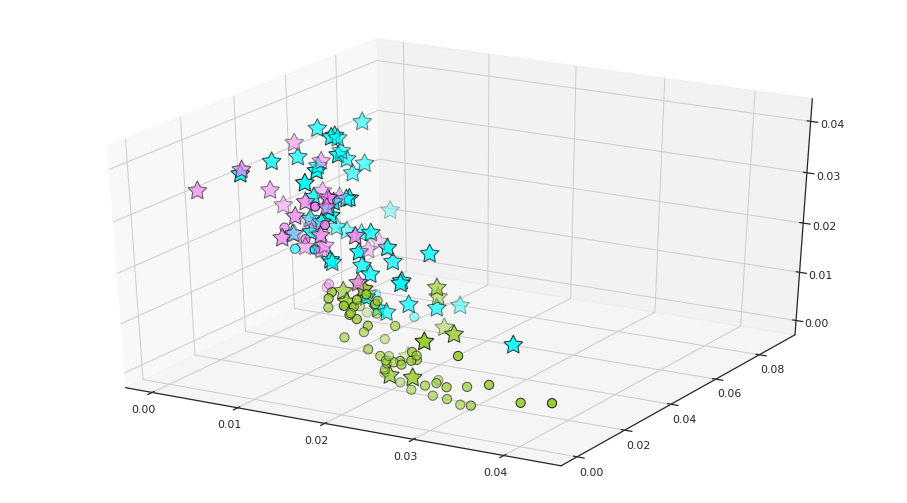

In [ ]:

from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (16, 9))

ax = plt.axes(projection ="3d")

#look at training sites in 3D

ax.scatter3D(group9['G1'], group9['G2'],group9['G3'], c=c1,edgecolors='k',s=85,marker='o', label=label9)
ax.scatter3D(group10['G1'], group10['G2'],group10['G3'], c=c2,edgecolors='k',s=85,marker='o', label=label10)
ax.scatter3D(group11['G1'], group11['G2'],group11['G3'], c=c3,edgecolors='k',s=85,marker='o', label=label11)
ax.scatter3D(group12['G1'], group12['G2'],group12['G3'], c=c4,edgecolors='k',s=85,marker='o', label=label12)



ax.scatter3D(group5['G1'], group5['G2'],group5['G3'], c=c1,edgecolors='k',s=385,marker=(5, 1), label=label5)
ax.scatter3D(group6['G1'], group6['G2'],group6['G3'], c=c2,edgecolors='k',s=385, marker=(5, 1), label=label6)
ax.scatter3D(group7['G1'], group7['G2'],group7['G3'], c=c3,edgecolors='k',s=385, marker=(5, 1),label=label7)
ax.scatter3D(group8['G1'], group8['G2'],group8['G3'], c=c4,edgecolors='k',s=385, marker=(5, 1),label=label8)

plt.savefig('March_Figs/NMF/FRWY/NMF_FRWY' + str(components) + ' 3D_Cluster ' +'Set' + str(feature_set)  + '.png')

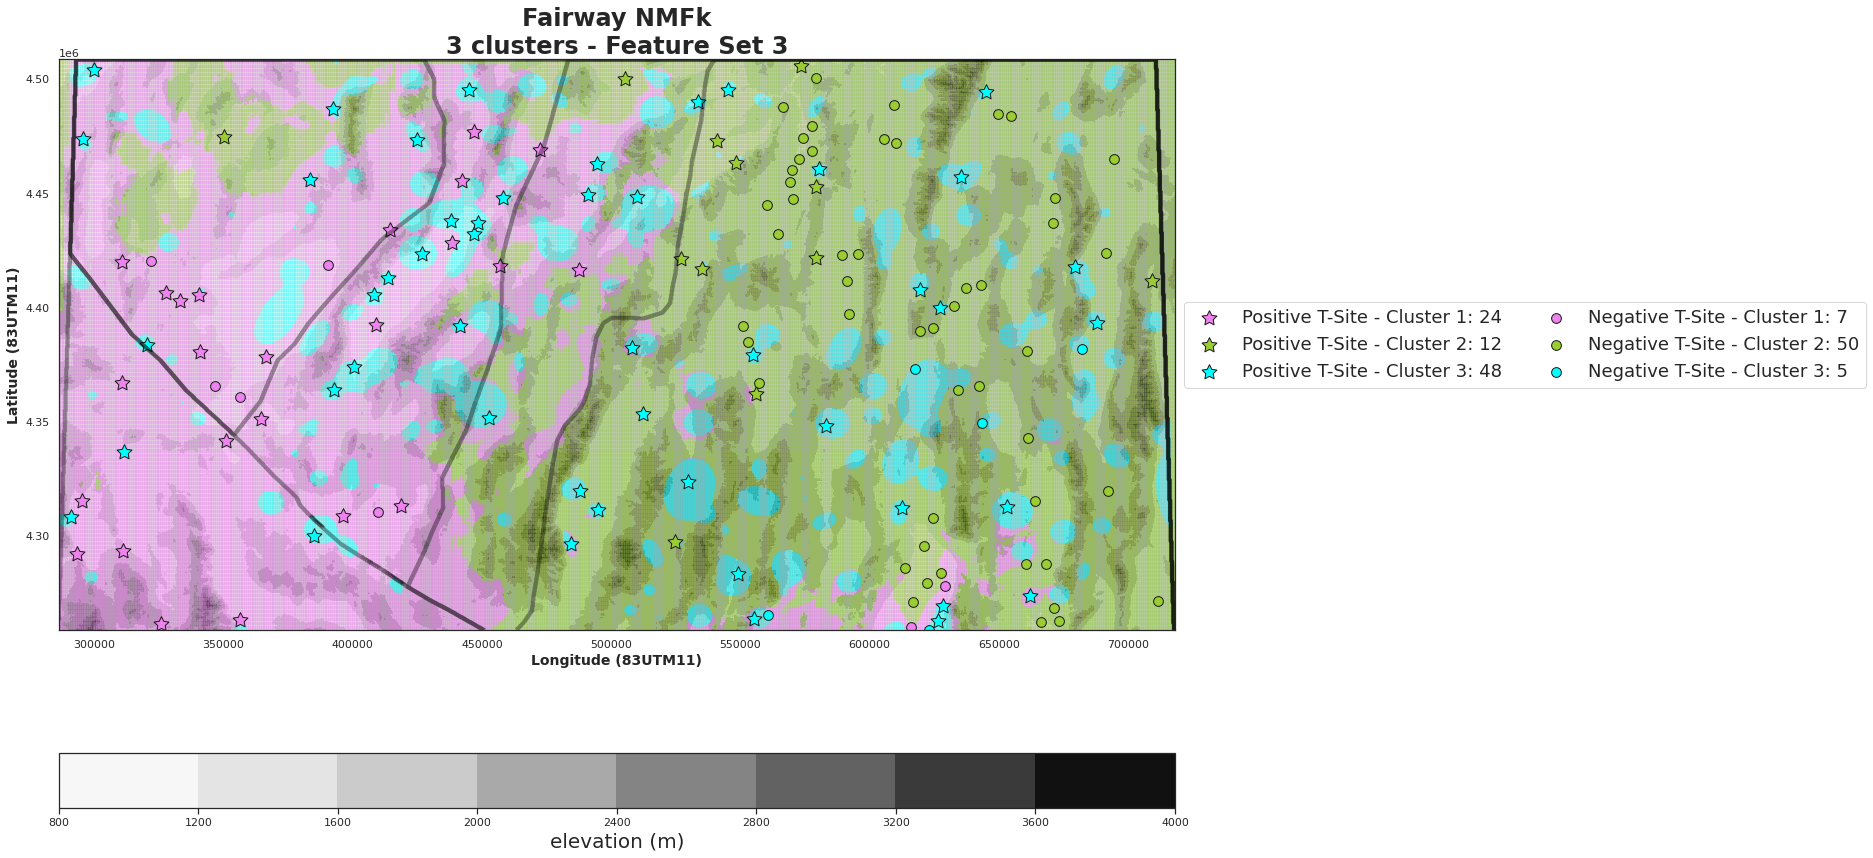

In [ ]:
plt.subplots(figsize=(20,15))

#Set up mesh grid plot for Domains and DEM
a = Info['X_83UTM11']
b = Info['Y_83UTM11']
Domains = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values
DEM = df_features.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values
X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)

plt.contour(Xa,Ya,Domains,colors='black', linewidths=4, alpha=0.2) 

plt.contourf(Xa,Ya,DEM,cmap = 'Greys')
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')

#Plot all points
plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'], c=c1,marker='.',s=0.05,alpha = 0.5)
plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'], c=c2, marker='.',s=0.05, alpha = 0.5)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'], c=c3, marker='.',s=0.05, alpha = 0.5)
#plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c=c4, marker='.',s=0.05,alpha = 0.5)

#Plot structures
#plt.scatter(group13['X_83UTM11'], group13['Y_83UTM11'], c='darkgreen',s=1,marker='.',alpha = 0.4, label=label13)
#plt.scatter(group14['X_83UTM11'], group14['Y_83UTM11'], c='blue',s=1,marker='.',alpha = 0.4, label=label14)
#plt.scatter(group15['X_83UTM11'], group15['Y_83UTM11'], c='darkviolet',s=1,marker='.',alpha = 0.4, label=label15)
#plt.scatter(group16['X_83UTM11'], group16['Y_83UTM11'], c='darkred',s=1,marker='.',alpha = 0.4, label=label16)

#Plot positive sites
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'],  c=c1,edgecolors='k', marker=(5, 1),s=245, label=label5)
plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'],  c=c2, edgecolors='k',marker=(5, 1),s=245,label=label6)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'], c=c3, edgecolors='k',marker=(5, 1),s=245, label=label7)
#plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'], c=c4, edgecolors='k',marker=(5, 1),s=245,label=label8)

#Plot negative sites
plt.scatter(group9['X_83UTM11'], group9['Y_83UTM11'],  c=c1, marker='o',edgecolors='k',s=95,label=label9)
plt.scatter(group10['X_83UTM11'], group10['Y_83UTM11'], c=c2, marker='o',edgecolors='k',s=95,label=label10)
plt.scatter(group11['X_83UTM11'], group11['Y_83UTM11'], c=c3, marker='o',edgecolors='k',s=95,label=label11)
#plt.scatter(group12['X_83UTM11'], group12['Y_83UTM11'], c=c4, marker='o',edgecolors='k',s=95,label=label12)



ncols = 2
plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', ncol=ncols, bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)

plt.title('Fairway NMFk\n' + str(nCluster) + ' clusters - Feature Set ' + str(feature_set),fontsize=24,fontweight='bold');

plt.tight_layout
plt.savefig('March_Figs/NMF/FRWY/NMF_FRWY_MAP' + str(nCluster) +'Set' + str(feature_set)  +'.png')

In [ ]:
df_cluster = df_out['KMeansGrp']

df_cluster = df_cluster.copy().to_numpy()

img0 = np.reshape(df_cluster,(1000,-1))

#df_cluster.to_numpy().reshape(1000,-1)
#img0 = np.reshape(df_cluster,(1000,-1))

img0.shape

#df_cluster.shape

(1000, 1728)

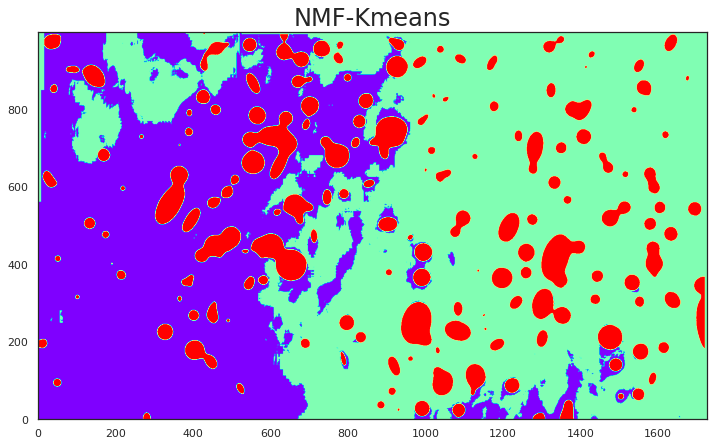

In [ ]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(12,12))
im = plt.imshow(img0, origin='lower', cmap = 'rainbow'
# norm=colors.Normalize(vmin=0.0, vmax=1.0)
# norm=colors.SymLogNorm(linthresh=0.3, linscale=0.3, vmin=-1.0, vmax=1.0, base=10))
)
plt.title('NMF-Kmeans',fontsize = 24)
divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="3%", pad=0.1)
#cb = plt.colorbar(im, cax=cax)
#cb.set_label('feature value',fontsize=16)
ax.grid(False)

## save maps as geotiffs

In [ ]:
import osgeo.gdal as gdal

import osgeo.osr as osr

In [ ]:
transform = [286202.6902, 250.0, 0.0, 4508588.7659, 0.0, -250.0]

In [ ]:
img0 = np.flipud(img0)
# img1 = np.flipud(imgm)
# img2 = np.flipud(imgmax)

In [ ]:
height = img0.shape[0]
width = img0.shape[1]
print (width, height)

1728 1000


In [ ]:
# open a new file
geotiffFile = 'NMFk_Figs/NMF_1-3_k_FeatureSet_'+str(feature_set)+'.tif'

driver = gdal.GetDriverByName("GTiff")
outRaster = driver.Create(geotiffFile, width, height, 1, gdal.GDT_Float32)

# use PFA's geo-transform found above
outRaster.SetGeoTransform(transform)

# assign color band
outband = outRaster.GetRasterBand(1)
outband.WriteArray(img0)

# set coordinate reference system
outRasterSRS = osr.SpatialReference() # create instance of class
outRasterSRS.ImportFromEPSG(26911)    # set to specific coordinate reference system
# outRasterSRS.ImportFromWkt(raster.GetProjectionRef()) # or could use SRS from before
outRaster.SetProjection(outRasterSRS.ExportToWkt()) # set the projection

# flush output to file
outband.FlushCache()

# this closes the files
raster = None
outRaster = None

